In [28]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy
import ast
import csv
import numpy as np

dataset = Planetoid(root='../data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [29]:
GCN_GNNExplainer_explanations = {}
GCN_IG_explanations = {}
GAT_GNNExplainer_explanations = {}
GAT_IG_explanations = {}

with open("../results/Explanations_GCN_GNNExplainer.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GCN_GNNExplainer_explanations[index] = (node_indices_list, node_weights_list)

with open("../results/Explanations_GCN_IntegratedGradients.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GCN_IG_explanations[index] = (node_indices_list, node_weights_list)

with open("../results/Explanations_GAT_GNNExplainer.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GAT_GNNExplainer_explanations[index] = (node_indices_list, node_weights_list)

with open("../results/Explanations_GAT_IntegratedGradients.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            node_indices = row[1]
            node_indices_list = ast.literal_eval(node_indices)
            node_weights = row[2]
            node_weights_list = ast.literal_eval(node_weights)
            GAT_IG_explanations[index] = (node_indices_list, node_weights_list)

In [123]:
def get_node_frequencies(explanations, significant_node_masks):
    node_frequencies_big = defaultdict(int)
    node_frequencies_small = defaultdict(int)

    for i, (node_indices, node_weights) in explanations.items():
        node_indices = torch.tensor(node_indices)
        node_weights = torch.tensor(node_weights)

        significant_node_mask_big = node_weights > significant_node_masks[0]
        significant_node_mask_small = node_weights > significant_node_masks[1]
        significant_nodes_big = node_indices[significant_node_mask_big]
        significant_nodes_small = node_indices[significant_node_mask_small]

        significant_nodes_big = np.unique(significant_nodes_big.numpy())
        significant_nodes_small = np.unique(significant_nodes_small.numpy())

        for node in significant_nodes_big:
            node_frequencies_big[node] += 1

        for node in significant_nodes_small:
            node_frequencies_small[node] += 1

    return node_frequencies_big, node_frequencies_small


GCN_GNNExplainer_node_freq_big, GCN_GNNExplainer_node_freq_small = get_node_frequencies(GCN_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GCN_IG_node_freq_big, GCN_IG_node_freq_small = get_node_frequencies(GCN_IG_explanations, significant_node_masks=(0.003, 0.0001))
GAT_GNNExplainer_node_freq_big, GAT_GNNExplainer_node_freq_small = get_node_frequencies(GAT_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GAT_IG_node_freq_big, GAT_IG_node_freq_small = get_node_frequencies(GAT_IG_explanations, significant_node_masks=(0.003, 0.0001))

In [124]:
def divide_into_chunks(freq, n):
    lst = sorted(freq.items(), key=lambda x: x[1])
    """Divide the list lst into n equally-sized chunks."""
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


num_bins = 10
GCN_GNNExplainer_bins_big = divide_into_chunks(GCN_GNNExplainer_node_freq_big, num_bins)
GCN_GNNExplainer_bins_small = divide_into_chunks(GCN_GNNExplainer_node_freq_small, num_bins)
GCN_IG_bins_big = divide_into_chunks(GCN_IG_node_freq_big, num_bins)
GCN_IG_bins_small = divide_into_chunks(GCN_IG_node_freq_small, num_bins)
GAT_GNNExplainer_bins_big = divide_into_chunks(GAT_GNNExplainer_node_freq_big, num_bins)
GAT_GNNExplainer_bins_small = divide_into_chunks(GAT_GNNExplainer_node_freq_small, num_bins)
GAT_IG_bins_big = divide_into_chunks(GAT_IG_node_freq_big, num_bins)
GAT_IG_bins_small = divide_into_chunks(GAT_IG_node_freq_small, num_bins)

In [125]:
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
GCN_model = GCN(hidden_channels=16)

In [126]:
GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def GCN_train():
    GCN_model.train()
    GCN_optimizer.zero_grad()
    out = GCN_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    GCN_optimizer.step()
    return loss

def GCN_test(mask):
    GCN_model.eval()
    out = GCN_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

In [127]:
for epoch in range(1, 101):
    loss = GCN_train()
    val_acc = GCN_test(data.val_mask)
    test_acc = GCN_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9465, Val: 0.1660, Test: 0.1630
Epoch: 002, Loss: 1.9419, Val: 0.3220, Test: 0.3800
Epoch: 003, Loss: 1.9363, Val: 0.1880, Test: 0.2200
Epoch: 004, Loss: 1.9290, Val: 0.1780, Test: 0.2060
Epoch: 005, Loss: 1.9199, Val: 0.2280, Test: 0.2680
Epoch: 006, Loss: 1.9140, Val: 0.2800, Test: 0.3250
Epoch: 007, Loss: 1.9079, Val: 0.3440, Test: 0.3740
Epoch: 008, Loss: 1.8992, Val: 0.3740, Test: 0.4030
Epoch: 009, Loss: 1.8876, Val: 0.4040, Test: 0.4380
Epoch: 010, Loss: 1.8764, Val: 0.4280, Test: 0.4760
Epoch: 011, Loss: 1.8656, Val: 0.4660, Test: 0.4950
Epoch: 012, Loss: 1.8626, Val: 0.4840, Test: 0.5200
Epoch: 013, Loss: 1.8460, Val: 0.5080, Test: 0.5280
Epoch: 014, Loss: 1.8329, Val: 0.5200, Test: 0.5320
Epoch: 015, Loss: 1.8225, Val: 0.5280, Test: 0.5380
Epoch: 016, Loss: 1.8167, Val: 0.5520, Test: 0.5730
Epoch: 017, Loss: 1.7995, Val: 0.5880, Test: 0.5930
Epoch: 018, Loss: 1.7878, Val: 0.6080, Test: 0.6250
Epoch: 019, Loss: 1.7716, Val: 0.6100, Test: 0.6350
Epoch: 020, 

In [128]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

GAT_model = GAT(hidden_channels=8, heads=8)
print(GAT_model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [129]:
GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def GAT_train():
    GAT_model.train()
    GAT_optimizer.zero_grad()
    out = GAT_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    GAT_optimizer.step()
    return loss

def GAT_test(mask):
    GAT_model.eval()
    out = GAT_model(data.x, data.edge_index)
    out = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [130]:
for epoch in range(1, 101):
    loss = GAT_train()
    val_acc = GAT_test(data.val_mask)
    test_acc = GAT_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9438, Val: 0.3780, Test: 0.4090
Epoch: 002, Loss: 1.9364, Val: 0.5680, Test: 0.5890
Epoch: 003, Loss: 1.9266, Val: 0.6180, Test: 0.6180
Epoch: 004, Loss: 1.9165, Val: 0.6200, Test: 0.6210
Epoch: 005, Loss: 1.9050, Val: 0.6620, Test: 0.6550
Epoch: 006, Loss: 1.8944, Val: 0.7160, Test: 0.7260
Epoch: 007, Loss: 1.8821, Val: 0.7680, Test: 0.7490
Epoch: 008, Loss: 1.8728, Val: 0.7700, Test: 0.7710
Epoch: 009, Loss: 1.8592, Val: 0.7940, Test: 0.7860
Epoch: 010, Loss: 1.8463, Val: 0.7960, Test: 0.7880
Epoch: 011, Loss: 1.8381, Val: 0.7980, Test: 0.7830
Epoch: 012, Loss: 1.8246, Val: 0.7960, Test: 0.7790
Epoch: 013, Loss: 1.8105, Val: 0.7960, Test: 0.7790
Epoch: 014, Loss: 1.7909, Val: 0.7920, Test: 0.7770
Epoch: 015, Loss: 1.7859, Val: 0.7880, Test: 0.7760
Epoch: 016, Loss: 1.7616, Val: 0.7860, Test: 0.7760
Epoch: 017, Loss: 1.7493, Val: 0.7880, Test: 0.7780
Epoch: 018, Loss: 1.7317, Val: 0.7900, Test: 0.7760
Epoch: 019, Loss: 1.7235, Val: 0.7900, Test: 0.7770
Epoch: 020, 

In [131]:
import torch_geometric.utils as pyg_utils


def generate_perturbations(data, nodes_to_remove):
    data = copy.deepcopy(data)
    nodes_to_remove = set(nodes_to_remove)

    mask = torch.ones(data.x.size(0), dtype=torch.bool)
    mask[list(nodes_to_remove)] = False
    
    data.x = data.x[mask]

    all_nodes = set(range(2708))
    nodes_to_retain = all_nodes.difference(nodes_to_remove)
    data.edge_index = pyg_utils.subgraph(sorted(nodes_to_retain), data.edge_index, relabel_nodes=True)[0]

    return data, mask


def get_logit_diff(data, perturbed_data, model, mask):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index)
        out_perturb = model(perturbed_data.x, perturbed_data.edge_index)
        logit_diff = out_orig[mask] - out_perturb
        l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
    return l2_norm

In [132]:
num_samples = 10

GCN_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GCN_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GCN_IG_results_small = torch.zeros(num_bins, num_samples)
GCN_IG_results_big = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GAT_IG_results_small = torch.zeros(num_bins, num_samples)
GAT_IG_results_big = torch.zeros(num_bins, num_samples)

GCN_GNNExplainer_avg_freq_small = []
GCN_GNNExplainer_avg_freq_big = []
GCN_IG_avg_freq_small = []
GCN_IG_avg_freq_big = []
GAT_GNNExplainer_avg_freq_small = []
GAT_GNNExplainer_avg_freq_big = []
GAT_IG_avg_freq_small = []
GAT_IG_avg_freq_big = []


def populate_result_tensors(bins, model, avg_freq, res):
    for i, bin in enumerate(bins):
        avg_freq.append(np.mean([i[1] for i in bin]))
        for j in range(num_samples):
            half_size = len(bin) // 2
            nodes = [i[0] for i in bin]
            sampled_nodes = random.sample(nodes, half_size)
            perturbed_data, mask = generate_perturbations(data, sampled_nodes)
            res[i, j] = get_logit_diff(data, perturbed_data, model, mask)


populate_result_tensors(GCN_GNNExplainer_bins_small, GCN_model, GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small)
populate_result_tensors(GCN_GNNExplainer_bins_big, GCN_model, GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big)
populate_result_tensors(GCN_IG_bins_small, GCN_model, GCN_IG_avg_freq_small, GCN_IG_results_small)
populate_result_tensors(GCN_IG_bins_big, GCN_model, GCN_IG_avg_freq_big, GCN_IG_results_big)
populate_result_tensors(GAT_GNNExplainer_bins_small, GAT_model, GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small)
populate_result_tensors(GAT_GNNExplainer_bins_big, GAT_model, GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big)
populate_result_tensors(GAT_IG_bins_small, GAT_model, GAT_IG_avg_freq_small, GAT_IG_results_small)
populate_result_tensors(GAT_IG_bins_big, GAT_model, GAT_IG_avg_freq_big, GAT_IG_results_big)

In [133]:
GCN_baseline_big = torch.zeros(num_samples)
GCN_baseline_small = torch.zeros(num_samples)
GAT_baseline_big = torch.zeros(num_samples)
GAT_baseline_small = torch.zeros(num_samples)


def populate_baseline_tensors(freq, bins, model, res):
    for i in range(num_samples):
        half_size = len(bins[0]) // 2
        nodes = [i[0] for i in freq.items()]
        sampled_nodes = random.sample(nodes, half_size)
        perturbed_data, mask = generate_perturbations(data, sampled_nodes)
        res[i] = get_logit_diff(data, perturbed_data, model, mask)


populate_baseline_tensors(GCN_GNNExplainer_node_freq_big, GCN_GNNExplainer_bins_big, GCN_model, GCN_baseline_big)
populate_baseline_tensors(GCN_GNNExplainer_node_freq_small, GCN_GNNExplainer_bins_small, GCN_model, GCN_baseline_small)
populate_baseline_tensors(GAT_GNNExplainer_node_freq_big, GAT_GNNExplainer_bins_big, GAT_model, GAT_baseline_big)
populate_baseline_tensors(GAT_GNNExplainer_node_freq_small, GAT_GNNExplainer_bins_small, GAT_model, GAT_baseline_small)

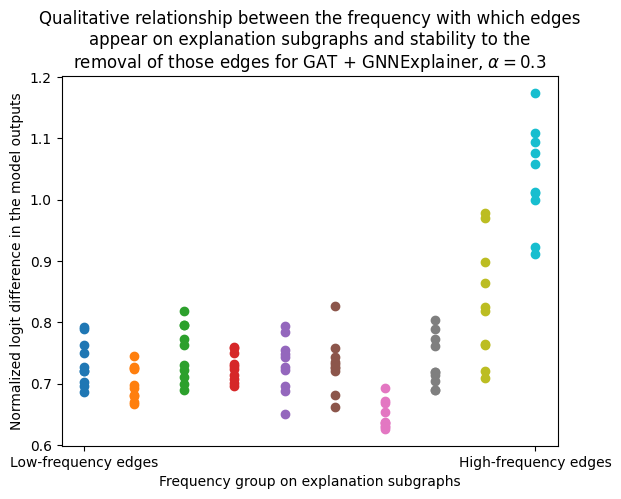

In [134]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(num_bins):
    x = [i] * num_samples
    y = GCN_GNNExplainer_results_small[i].detach().numpy()
    ax.scatter(x, y, label=f'Bin {i+1}')

ax.set_xlabel('Frequency group on explanation subgraphs')
ax.set_ylabel('Normalized logit difference in the model outputs')
ax.set_xticks([0, num_bins-1])  # Set ticks only at the extremes
ax.set_xticklabels(['Low-frequency edges', 'High-frequency edges'])
ax.set_title('Qualitative relationship between the frequency with which edges\nappear on explanation subgraphs and stability to the\nremoval of those edges for GAT + GNNExplainer, $\\alpha=0.3$')
plt.show()

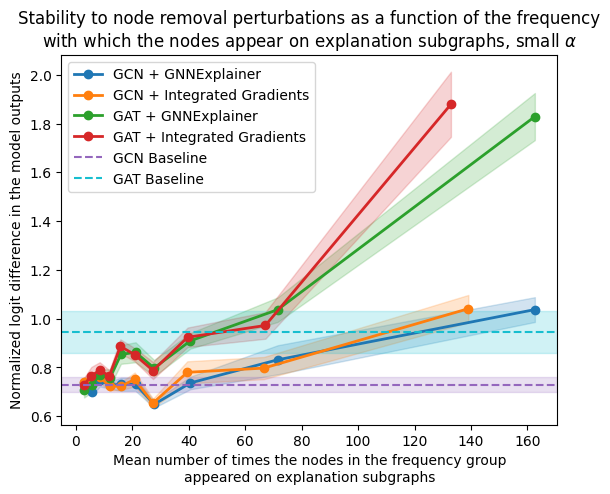

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)


def plot_baseline(baseline, label, color):
    mean = np.mean(baseline)
    sem_baseline = sem(baseline)

    ci_lower = mean - 1.96 * sem_baseline
    ci_upper = mean + 1.96 * sem_baseline

    plt.axhline(y=mean, color=color, linestyle='--', label=label)
    plt.fill_between([0, 1], ci_lower, ci_upper, color=color, alpha=0.2, transform=plt.gca().get_yaxis_transform())


plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_small, GCN_IG_results_small.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_small, GAT_IG_results_small.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_small.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_small.numpy(), "GAT Baseline", colors[5])
# plot_with_confidence_intervals(tagcn_avg_freq_small, tagcn_results_small.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to node removal perturbations as a function of the frequency\nwith which the nodes appear on explanation subgraphs, small $\\alpha$')
plt.show()

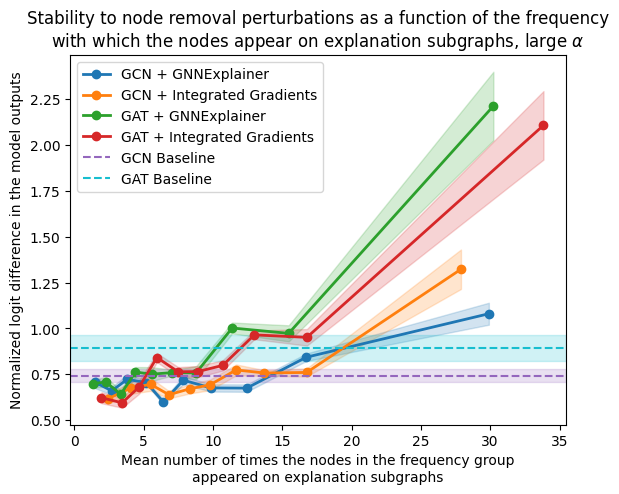

In [136]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_big, GCN_IG_results_big.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_big, GAT_IG_results_big.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_big.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_big.numpy(), "GAT Baseline", colors[5])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to node removal perturbations as a function of the frequency\nwith which the nodes appear on explanation subgraphs, large $\\alpha$')
plt.show()